In [75]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import astropy.time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from momenta.io import GW, NuDetector, SuperNuDetector, Parameters, NuEvent, transient
from momenta.io.neutrinos import BackgroundFixed, BackgroundPoisson
from momenta.io.neutrinos_irfs import EffectiveAreaAllSky
from momenta.io.transient import PointSource
from momenta.stats.run import run_ultranest
from momenta.stats.constraints import get_limits, upperlimit_from_sample
import momenta.utils.conversions
import momenta.utils.flux as flux

# An example of good formatting

For a 2D example, we build our tabulated flux from an analytical function.

The software only accepts tabulated fluxes with 1 or 2 free parameters, so we use a broken power law with a fixed break energy in our example.

In [76]:
bpl = flux.AsymmetricBrokenPowerLaw(1e-1, 1e7, (2, 5, 16), (0, 3, 10), (3, 3, 1))

#The two spectral indices of the bpl are the free parameters.
spectral_idx1 = bpl.shapevar_grid[0]
spectral_idx2 = bpl.shapevar_grid[1] 

#We build the dataframe that will be our input as tabulated data. 
#It is a (len(alphas)*len(betas)*len(energy), 4) DataFrame, containing the energy-flux pair for each parameter combination
e_range = np.logspace(-1,7,100)
df_list = []
for a in spectral_idx1:
    for b in spectral_idx2:
        bpl.set_shapevars([a, b, 3])
        fluxes = bpl.evaluate(e_range)
        df_dict = {'energy': e_range,
                   'flux': fluxes,
                   'spectral_idx1': [a]*len(e_range),
                   'spectral_idx2': [b]*len(e_range)}
        df = pd.DataFrame(df_dict)
        df_list.append(df)

good_input = pd.concat(df_list, ignore_index=True)


#And finally, the flux from the tabulated data
tab_flux = flux.VariableTabulated2D(good_input)

# Simple analysis example for a tabulated flux with 1 free parameter.

Again, we build our tabulated data from an analytical function, a single power-law.

In [77]:
spl = flux.VariablePowerLaw(1e-1, 1e7, gamma_range=(1, 4, 16))
gammas = spl.shapevar_grid[0]

e_range = np.logspace(-1, 7, 100)
df_list = []
for g in gammas:
    spl.set_shapevars([g])
    fluxes = spl.evaluate(e_range)
    df_dict = {'energy': e_range,
                'flux': fluxes,
                'gamma': [g]*len(e_range)}
    df = pd.DataFrame(df_dict)
    df_list.append(df)

good_input1D = pd.concat(df_list, ignore_index=True)
tab1D = flux.VariableTabulated1D(good_input1D)
flux1D = flux.FluxBase()
flux1D.components.append(tab1D)
    

## Detector, flux, and observation setup 

See "full_example" for details

In [93]:
detector = NuDetector(
    {
        "name": "Detector",
        "samples": ["Sample"],
    }
)


parameters = Parameters("input_files/config.yaml")
parameters.set_models(flux=flux1D)

source = PointSource(288.2645, 19.7735, 0, name="GRB 221009A", utc=astropy.time.Time("2022-10-09T13:17:00"))



# Custom effective area that is constant over the full sky and just depends on energy
class EffAreaDet(EffectiveAreaAllSky):
    def evaluate(self, energy, ipix, nside):
        return (energy / 10) ** 3 * np.exp(-energy / 30000)


detector.set_effective_areas([EffAreaDet()])

bkg1 = [BackgroundPoisson(10, 20)]
nobs1 = [0]

# Filling values to the detector objects
detector.set_observations(nobs1, bkg1)


[2025-06-16 17:16:12,253:momenta:INFO] [NuDetector] Object is loaded from a dictionary object.


## Compute the posterior distribution 

In [81]:
model, result = run_ultranest(detector, source, parameters)

Limit on E^2 dN/dE for tabulated = 595.1078159794173 GeV/cm²


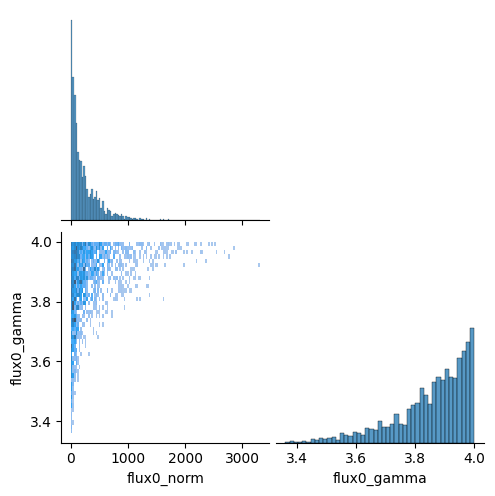

In [91]:
import seaborn as sns
df1D = pd.DataFrame(result["samples"])[["flux0_norm", "flux0_" + tab1D.shapevar_names[0]]]
g = sns.pairplot(df1D, kind='hist', corner=True)
ul_tab = upperlimit_from_sample(result["samples"]['flux0_norm']) 
print(f"Limit on E^2 dN/dE for tabulated = {ul_tab} GeV/cm²")


## Check consistency with the analytic results

Limit on E^2 dN/dE for tabulated = 595.1078159794173 GeV/cm²
Limit on E^2 dN/dE for analytic = 618.3461418499012 GeV/cm²


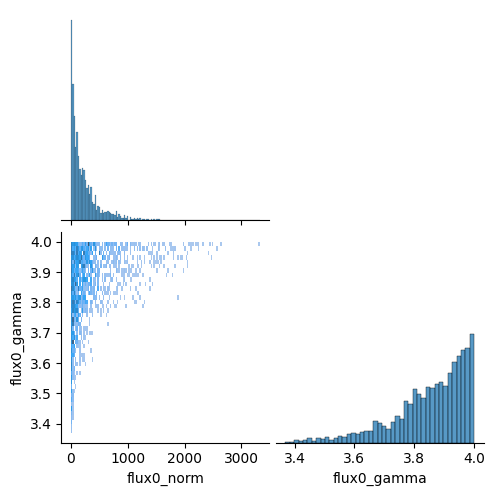

In [92]:
parameters.flux = flux.FluxBase()
parameters.flux.components.append(spl)
model_ana, result_ana = run_ultranest(detector, source, parameters)

df_ana = pd.DataFrame(result_ana["samples"])[["flux0_norm", "flux0_" + spl.shapevar_names[0]]]
sns.pairplot(df_ana, kind='hist', corner=True)

print(f"Limit on E^2 dN/dE for tabulated = {ul_tab} GeV/cm²")

ul_ana = upperlimit_from_sample(result_ana["samples"]['flux0_norm']) 
print(f"Limit on E^2 dN/dE for analytic = {ul_ana} GeV/cm²")